# Using File-Formats and exploring Resources

Pre-Processing your data requires you to be somewhat familier with three aspects related to file formats on the one hand and system resources on the other:
    
1. The data model that is implemented by data description formats such as HDF5 and NetCDF (We covered those already in the lecture slides)
2. Some idea of the Application Programming Interface (API) that the related helper utilities and libraries expose for you to use.
3. A basic system understanding to know which tuneables you might want to explore and activate/deactivate.
4. A performance expectation and a strategy to evalute how well you are doing in comparison what may be possible.

In this notebook you will become more familier with important basics on these 4 points. Exhaustively covering these is unfortunetly not possible. Technologies continue to evolve and some tools and details are only valid on particular systems, so that including them here may not be a good use of your time.

We can try, however,to equip you with familiarity with some common tools and a set of expectations that allow you to ask the right questions to the operators that are providing you with compute and storage resources.

In [149]:
# package imports we are going to need (please make yourself noticeable if this cell fails so we can help ;)
# The YAMLLoadWarning is expected and can be ignored.
import os
import netCDF4
import h5py
import xarray

# 0. HPC System Information

On your own computer you often only have a single storage device, and thus do not need to v
worry about different performance properties or quota and capacity limits.
This can differ on most supercopmuters and many cloud systems.

## Hardware Information

### CPU

In [150]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                48
On-line CPU(s) list:   0-47
Thread(s) per core:    2
Core(s) per socket:    12
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 63
Model name:            Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz
Stepping:              2
CPU MHz:               1200.000
CPU max MHz:           2501.0000
CPU min MHz:           1200.0000
BogoMIPS:              5000.01
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              30720K
NUMA node0 CPU(s):     0-11,24-35
NUMA node1 CPU(s):     12-23,36-47
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good xtopology

In [4]:
# in a terminal try top/htop (htop is not always available)

### Memory

In [5]:
# in a seperate terminal try:
# free -h

### GPUs

In [6]:
!nvidia-smi

Wed Sep 29 06:48:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:04:00.0 Off |                    0 |
| N/A   32C    P8    25W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   29C    P8    29W / 149W |     16MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

### Some Visual Tools

In [7]:
# in a seperate terminal try:
# cd ~/mardata/training/Tutorial_Part2 && lstopo --of png lstopo.png

## Storage Information and Locations to Store your Data

A good first step is therefor to familiarize with the available storage locations.
A useful utility to do so is for example the `df` command which lists available storage locations.

In [8]:
!df -h

Filesystem                                   Size  Used Avail Use% Mounted on
tmpfs                                         16M   12K   16M   1% /
/dev/loop3                                   4.6G  4.6G     0 100% /bin
devtmpfs                                     126G  292K  126G   1% /mnt/lustre01/spack-workplace/spack-rhel6/singularity-3.6.1-k6cdmk/var/singularity/mnt/session/final/dev
/dev/mapper/vg_01-lv_tmp                     408G   78M  387G   1% /tmp
tmpfs                                        126G  628K  126G   1% /dev/shm
/dev/mapper/vg_01-lv_root                     50G   17G   30G  36% /var/tmp
10.50.32.53@o2ib:10.50.32.54@o2ib:/lustre01   21P   18P  2.8P  87% /work
10.50.33.12@o2ib:10.50.33.13@o2ib:/lustre02   33P   29P  3.5P  90% /mnt/lustre02


In [9]:
!lsblk

NAME             MAJ:MIN RM   SIZE RO TYPE MOUNTPOINT
loop0              7:0    0   4.6G  1 loop 
loop1              7:1    0   4.6G  1 loop 
loop2              7:2    0   4.6G  1 loop 
loop3              7:3    0   4.6G  1 loop /mnt/lustre01/spack-workplace/spack-r
sda                8:0    0 465.8G  0 disk 
├─sda1             8:1    0   500M  0 part 
└─sda2             8:2    0 465.3G  0 part 
  ├─vg_01-lv_root
  │              253:0    0    50G  0 lvm  /mnt/lustre01/spack-workplace/spack-r
  ├─vg_01-lv_swap
  │              253:1    0  1000M  0 lvm  [SWAP]
  └─vg_01-lv_tmp 253:2    0 414.3G  0 lvm  /mnt/lustre01/spack-workplace/spack-r


In many cases, especially for files that are not large datasets (think multiple hundreds of MiB or GiB) there is usually no need to look beyond the `PATH` of your dataset.
When you are dealing with large datasets however, you can quickly run out of quota or will be notified by a sites operating to change how you are using the system.

Very common are the following three locations to look out for:

* `/home/<username>`: Your home directory, use mostly for user configuration und links to your projects. Some sites discourage users from storing large amounts of data in here, especially if backups are provided
* `/work/<project>`: Typically your project gets some storage capacity granted for which the site provides you with a path were to store your project data
* `/scratch/...`: It is common to create many files that are only temporarilly needed when running applications or pre/post-processing tasks. As it is easy to forget or can become very cumbersome to keep track manually which files can be deleted, some locations come with "automatic" housekeeping routines. The scratch space is often not counted against your quota, but data in this locations will automatically deleted after some time if you do not move or copy it to a permanent location.

Usually a site documents their recommendations somewhere. DKRZ, for example, has a entry on file systems in its wiki: https://www.dkrz.de/up/systems/mistral/file-systems

Often it is useful to define a link in the filesystem or a variable in your program that allows you to easily change storage locations, without needing to search and replace hardcoded locations:

In [151]:
# a variable available all the following Python cells
DATA = "/mnt/lustre01/work/ka1176/shared_data/training/weatherbench"

In [25]:
# Your scratch space directory may not be automatically created, so you can create it yourself
SCRATCH = f'/mnt/lustre01/scratch/k/k202109'
!mkdir -p "{SCRATCH}"

# Sometimes, a variable with an absolute path is unconvienient to have in a code base.
# As an alternative you can work with relative paths in your program, or create symbolic links that points to the actual storage location.
# Here we create such a link which allows you to access the scratch space for example using "./scratch" as a your path
!ln -s "{SCRATCH}" scratch

ln: failed to create symbolic link 'scratch/k202109': File exists


In [115]:
# lets also create one for data
!ln -s "{DATA}" scratch

## Inspecting Files

In [13]:
# list files
!ls -lh

total 568K
-rw-r--r-- 1 k202109 ku0598  54K Sep 29 06:48 01_Exploring-System-Resources-and-File-Formats.ipynb
-rw-r--r-- 1 k202109 ku0598  22K Sep 28 13:51 02_CyGNSS_RawData_To_PyTorch.ipynb
-rw-r--r-- 1 k202109 ku0598 280K Sep 29 00:00 data.h5
-rw-r--r-- 1 k202109 ku0598 1.4K Sep 29 00:00 data_chunked.h5
-rw-r--r-- 1 k202109 ku0598  71K Sep 28 18:44 logical.png
-rw-r--r-- 1 k202109 ku0598  63K Sep 29 06:34 lstopo.png
-rw-r--r-- 1 k202109 ku0598  62K Sep 28 18:44 physical.png
lrwxrwxrwx 1 k202109 ku0598   31 Sep 29 06:22 scratch -> /mnt/lustre01/scratch/k/k202109
-rw-r--r-- 1 k202109 ku0598  331 Sep 28 18:56 test.nc


In [20]:
# Look our for the "Inode" of the link itself
!stat ./scratch

  File: ./scratch -> /mnt/lustre01/scratch/k/k202109
  Size: 31        	Blocks: 0          IO Block: 4096   symbolic link
Device: 4f53a12ah/1330880810d	Inode: 144123863154856523  Links: 1
Access: (0777/lrwxrwxrwx)  Uid: (23913/ k202109)   Gid: ( 1301/  ku0598)
Access: 2021-09-29 06:22:41.000000000 +0200
Modify: 2021-09-29 06:22:41.000000000 +0200
Change: 2021-09-29 06:22:41.000000000 +0200
 Birth: -


In [123]:
# And the actual entry when providing the true path:
!stat "{SCRATCH}"

stat: cannot stat '{SCRATCH}': No such file or directory


## 1. Data Formats

In the lecture earlier we already saw examples for different technologies and learned how they relate to each other.
In this notebook we will take a handson approach to get started with using some of these.

## Command-line Utilities

Much of the still existing tooling did not consider Python as the primary mode of usage:
* Applications typically would have used a C or Fortran API to access HDF5 or NetCDF.
* Users most of the time used various command-line interface (CLI) utilities to interact.

These are still useful today, even though most of the information can also be accessed from the Python API we will learn about later.

**Task:** Briefly familiarize yourself with the two utilities `h5dump` and `ncdump` to display some basic information.

In [23]:
!h5dump --help

usage: h5dump [OPTIONS] files
  OPTIONS
     -h,   --help         Print a usage message and exit
     -V,   --version      Print version number and exit
--------------- File Options ---------------
     -n,   --contents     Print a list of the file contents and exit
                          Optional value 1 also prints attributes.
     -B,   --superblock   Print the content of the super block
     -H,   --header       Print the header only; no data is displayed
     -f D, --filedriver=D Specify which driver to open the file with
     -o F, --output=F     Output raw data into file F
     -b B, --binary=B     Binary file output, of form B
     -O F, --ddl=F        Output ddl text into file F
                          Use blank(empty) filename F to suppress ddl display
--------------- Object Options ---------------
     -a P, --attribute=P  Print the specified attribute
                          If an attribute name contains a slash (/), escape the
                          slash with a 

In [75]:
!ncdump

ncdump [-c|-h] [-v ...] [[-b|-f] [c|f]] [-l len] [-n name] [-p n[,n]] [-k] [-x] [-s] [-t|-i] [-g ...] [-w] [-Ln] file
  [-c]             Coordinate variable data and header information
  [-h]             Header information only, no data
  [-v var1[,...]]  Data for variable(s) <var1>,... only
  [-b [c|f]]       Brief annotations for C or Fortran indices in data
  [-f [c|f]]       Full annotations for C or Fortran indices in data
  [-l len]         Line length maximum in data section (default 80)
  [-n name]        Name for netCDF (default derived from file name)
  [-p n[,n]]       Display floating-point values with less precision
  [-k]             Output kind of netCDF file
  [-s]             Output special (virtual) attributes
  [-t]             Output time data as date-time strings
  [-i]             Output time data as date-time strings with ISO-8601 'T' separator
  [-g grp1[,...]]  Data and metadata for group(s) <grp1>,... only
  [-w]             With client-side caching of variabl

## 2. HDF5 & NetCDF: Lower-level APIs even though you may most often use xarray 

HDF5 and NetCDF are two popular data formats used by many scientists. Especially NetCDF is common in the climate sciences.
in the following two sections we will have a closer look at their APIs and the resulting data that is written to disk using the h5dump and ncdump utilities.

In [106]:
# Use this to reset your working directory in case you ran the notebook already, because some of the examples are ment to operate on files that should not exist yet
!rm -f data.h5 data_chunked.h5 data_compressed.h5 data.nc

#### Writing HDF5

In [99]:
import numpy as np
import h5py

In [100]:
d1 = np.random.random(size = (1000,20))
d2 = np.random.random(size = (1000,200))

In [101]:
print(d1.shape, d2.shape)

(1000, 20) (1000, 200)


In [107]:
hf = h5py.File('data.h5', 'w')

In [108]:
hf.create_dataset('dataset_1', data=d1)
hf.create_dataset('dataset_2', data=d2)

<HDF5 dataset "dataset_2": shape (1000, 200), type "<f8">

In [109]:
hf.close()

In [110]:
!h5dump -Hp data.h5

HDF5 "data.h5" {
GROUP "/" {
   DATASET "dataset_1" {
      DATATYPE  H5T_IEEE_F64LE
      DATASPACE  SIMPLE { ( 1000, 20 ) / ( 1000, 20 ) }
      STORAGE_LAYOUT {
         CONTIGUOUS
         SIZE 160000
         OFFSET 2048
      }
      FILTERS {
         NONE
      }
      FILLVALUE {
         FILL_TIME H5D_FILL_TIME_IFSET
         VALUE  H5D_FILL_VALUE_DEFAULT
      }
      ALLOCATION_TIME {
         H5D_ALLOC_TIME_LATE
      }
   }
   DATASET "dataset_2" {
      DATATYPE  H5T_IEEE_F64LE
      DATASPACE  SIMPLE { ( 1000, 200 ) / ( 1000, 200 ) }
      STORAGE_LAYOUT {
         CONTIGUOUS
         SIZE 1600000
         OFFSET 162048
      }
      FILTERS {
         NONE
      }
      FILLVALUE {
         FILL_TIME H5D_FILL_TIME_IFSET
         VALUE  H5D_FILL_VALUE_DEFAULT
      }
      ALLOCATION_TIME {
         H5D_ALLOC_TIME_LATE
      }
   }
}
}


#### Reading HDF5

Similar to creating a HDF5 file you can also only read from it.


Documentation for the HDF5 Python API can be found at:

https://docs.h5py.org/en/stable/high/file.html#reference
https://docs.h5py.org/en/stable/high/group.html#reference
https://docs.h5py.org/en/stable/high/dataset.html#reference

In [93]:
hf = h5py.File('data.h5', 'r')

In [94]:
hf.keys()

<KeysViewHDF5 ['dataset_1', 'dataset_2', 'group1', 'group2']>

In [95]:
n1 = hf.get('dataset_1')
n1

<HDF5 dataset "dataset_1": shape (1000, 20), type "<f8">

In [96]:
n1 = np.array(n1)
n1.shape

(1000, 20)

In [97]:
hf.close()

### Working with Groups and Adding to Existing HDF5 Files

In [ ]:
d1 = np.random.random(size = (100,33))
d2 = np.random.random(size = (100,333))
d3 = np.random.random(size = (100,3333))

hf = h5py.File('data.h5', 'a')

g1 = hf.create_group('group1')

g1.create_dataset('data1',data=d1)
g1.create_dataset('data2',data=d1)

g2 = hf.create_group('group2/subfolder')
g2.create_dataset('data3',data=d3)

group2 = hf.get('group2/subfolder')
group2.items()

group1 = hf.get('group1')
group1.items()

n1 = group1.get('data1')
np.array(n1).shape

hf.close()

In [88]:
!h5dump -Hp data.h5

HDF5 "data.h5" {
GROUP "/" {
   DATASET "dataset_1" {
      DATATYPE  H5T_IEEE_F64LE
      DATASPACE  SIMPLE { ( 1000, 20 ) / ( 1000, 20 ) }
      STORAGE_LAYOUT {
         CONTIGUOUS
         SIZE 160000
         OFFSET 2048
      }
      FILTERS {
         NONE
      }
      FILLVALUE {
         FILL_TIME H5D_FILL_TIME_IFSET
         VALUE  H5D_FILL_VALUE_DEFAULT
      }
      ALLOCATION_TIME {
         H5D_ALLOC_TIME_LATE
      }
   }
   DATASET "dataset_2" {
      DATATYPE  H5T_IEEE_F64LE
      DATASPACE  SIMPLE { ( 1000, 200 ) / ( 1000, 200 ) }
      STORAGE_LAYOUT {
         CONTIGUOUS
         SIZE 1600000
         OFFSET 162048
      }
      FILTERS {
         NONE
      }
      FILLVALUE {
         FILL_TIME H5D_FILL_TIME_IFSET
         VALUE  H5D_FILL_VALUE_DEFAULT
      }
      ALLOCATION_TIME {
         H5D_ALLOC_TIME_LATE
      }
   }
   GROUP "group1" {
      DATASET "data1" {
         DATATYPE  H5T_IEEE_F64LE
         DATASPACE  SIMPLE { ( 100, 33 ) / ( 100, 33 ) }
     

### Add chunking

In [61]:
import h5py
import numpy as np

d1 = np.random.random(size = (100,33))
d2 = np.random.random(size = (100,333))
d3 = np.random.random(size = (100,3333))

hf = h5py.File('data_chunked.h5', 'w')
dset = hf.create_dataset("dataset", (1000, 1000), chunks=(100, 100))
hf.close()

In [62]:
!h5dump -Hp data_chunked.h5

HDF5 "data_chunked.h5" {
GROUP "/" {
   DATASET "dataset" {
      DATATYPE  H5T_IEEE_F32LE
      DATASPACE  SIMPLE { ( 1000, 1000 ) / ( 1000, 1000 ) }
      STORAGE_LAYOUT {
         CHUNKED ( 100, 100 )
         SIZE 0
      }
      FILTERS {
         NONE
      }
      FILLVALUE {
         FILL_TIME H5D_FILL_TIME_ALLOC
         VALUE  H5D_FILL_VALUE_DEFAULT
      }
      ALLOCATION_TIME {
         H5D_ALLOC_TIME_INCR
      }
   }
}
}


### Adding compressions

In [66]:
import h5py
import numpy as np

d1 = np.random.random(size = (100,33))
d2 = np.random.random(size = (100,333))
d3 = np.random.random(size = (100,3333))

hf = h5py.File('data_compressed.h5', 'w')

hf.create_dataset('dataset_1', data=d1, compression="gzip", compression_opts=9)
hf.create_dataset('dataset_2', data=d2, compression="gzip", compression_opts=6)

hf.close()

In [67]:
!h5dump -Hp data_compressed.h5

HDF5 "data_compressed.h5" {
GROUP "/" {
   DATASET "dataset_1" {
      DATATYPE  H5T_IEEE_F64LE
      DATASPACE  SIMPLE { ( 100, 33 ) / ( 100, 33 ) }
      STORAGE_LAYOUT {
         CHUNKED ( 50, 17 )
         SIZE 25182 (1.048:1 COMPRESSION)
      }
      FILTERS {
         COMPRESSION DEFLATE { LEVEL 9 }
      }
      FILLVALUE {
         FILL_TIME H5D_FILL_TIME_ALLOC
         VALUE  H5D_FILL_VALUE_DEFAULT
      }
      ALLOCATION_TIME {
         H5D_ALLOC_TIME_INCR
      }
   }
   DATASET "dataset_2" {
      DATATYPE  H5T_IEEE_F64LE
      DATASPACE  SIMPLE { ( 100, 333 ) / ( 100, 333 ) }
      STORAGE_LAYOUT {
         CHUNKED ( 13, 84 )
         SIZE 252397 (1.055:1 COMPRESSION)
      }
      FILTERS {
         COMPRESSION DEFLATE { LEVEL 6 }
      }
      FILLVALUE {
         FILL_TIME H5D_FILL_TIME_ALLOC
         VALUE  H5D_FILL_VALUE_DEFAULT
      }
      ALLOCATION_TIME {
         H5D_ALLOC_TIME_INCR
      }
   }
}
}


## NetCDF4

Another format very commonly found in earth and environment contexts is NetCDF4.
Modern NetCDF4 internally uses the HDF5 data format that is stored to storage, while preserving the simplefied API NetCDF users are used to.

About NetCDF: "The NetCDF library is designed to read and write data that has been structured according to well-defined rules and is easily ported across various computer platforms.
The netCDF interface enables but does not require the creation of self-describing datasets.
The purpose of the CF conventions is to require conforming datasets to contain sufficient metadata that they are self-describing in the sense that each variable in the file has an associated description of what it represents,
including physical units if appropriate,
and that each value can be located in space
(relative to earth-based coordinates)
and time."

http://cfconventions.org/Data/cf-conventions/cf-conventions-1.6/build/cf-conventions.html

In [38]:
import netCDF4 as nc

ncdset = nc.Dataset('data.nc', 'w')

In [39]:
ncdset.createDimension('t', None)
ncdset.createDimension('z', 40)
ncdset.createDimension('y', 898)
ncdset.createDimension('x', 398)

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 398

In [40]:
ncdset.close()

In [41]:
!ncdump data.nc

netcdf data {
dimensions:
	t = UNLIMITED ; // (0 currently)
	z = 40 ;
	y = 898 ;
	x = 398 ;
}


In [36]:
!h5dump -Hp data.nc

HDF5 "data.nc" {
GROUP "/" {
   ATTRIBUTE "_NCProperties" {
      DATATYPE  H5T_STRING {
         STRSIZE 55;
         STRPAD H5T_STR_NULLTERM;
         CSET H5T_CSET_ASCII;
         CTYPE H5T_C_S1;
      }
      DATASPACE  SCALAR
   }
   DATASET "t" {
      DATATYPE  H5T_IEEE_F32BE
      DATASPACE  SIMPLE { ( 0 ) / ( H5S_UNLIMITED ) }
      STORAGE_LAYOUT {
         CHUNKED ( 1 )
         SIZE 0
      }
      FILTERS {
         NONE
      }
      FILLVALUE {
         FILL_TIME H5D_FILL_TIME_IFSET
         VALUE  H5D_FILL_VALUE_DEFAULT
      }
      ALLOCATION_TIME {
         H5D_ALLOC_TIME_INCR
      }
      ATTRIBUTE "CLASS" {
         DATATYPE  H5T_STRING {
            STRSIZE 16;
            STRPAD H5T_STR_NULLTERM;
            CSET H5T_CSET_ASCII;
            CTYPE H5T_C_S1;
         }
         DATASPACE  SCALAR
      }
      ATTRIBUTE "NAME" {
         DATATYPE  H5T_STRING {
            STRSIZE 64;
            STRPAD H5T_STR_NULLTERM;
            CSET H5T_CSET_ASCII;
            

### XArray: High-level but sometimes not as performant as you might expect

Convienience vs. performance is a common struggle in computer science.

In [124]:
import xarray as xr

dataroot = DATA
resolution = "5.625"
variable = "temperature"

xr.open_mfdataset(f'{dataroot}/{resolution}deg/{variable}/*deg.nc', combine='by_coords')

<xarray.Dataset>
Dimensions:  (lat: 32, level: 13, lon: 64, time: 350640)
Coordinates:
  * level    (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    t        (time, level, lat, lon) float32 dask.array<chunksize=(8760, 13, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-03 19:31:21 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [1]:
# As the above can be cumbersome, lets define a little helper function to initialize a weatherbench multifile dataset
import xarray as xr

DATA = "/mnt/lustre01/work/ka1176/shared_data/training/weatherbench"

def mf_dataset(dataroot=None, resolution='5.625', variables=None, year=None, years=None, levels=None, chunks=None, combine=None):
    """ Return initialized multifile dataset.

    Args:
        dataroot (str): root directory containing weatherbench data
        resolution (str): which resolution data to load (default: 5.625) [5.625, 2.8125, 1.40625]
        variables (list): list of variables to include

    Return:
        xarray.dataset

    """

    if dataroot is None:
        dataroot = DATA

    if variables is None:
        variables = [        
            "10m_u_component_of_wind",
            "10m_v_component_of_wind",
            "2m_temperature",
            #"constants",
            "geopotential",
            #"geopotential_500",
            "potential_vorticity",
            "relative_humidity",
            "specific_humidity",
            "temperature",
            #"temperature_850",
            "toa_incident_solar_radiation",
            "total_cloud_cover",
            "total_precipitation",
            "u_component_of_wind",
            "v_component_of_wind",
            "vorticity"
            ]

    if chunks is None:
        chunks = {'lat': 10, 'lon': 10}
        
    if combine is None:
        combine='by_coords'
        #combine='nested'   
        
    datadir = f'{dataroot}/{resolution}deg/'

    handles = {}
    for variable in variables:
        if variable in ['constants']:
            handles[variable] = xr.open_mfdataset(f'{datadir}/{variable}/*deg.nc',
                    combine=combine,
                    chunks=chunks,
                    parallel=True,
                    lock=False)
            continue

        if year is not None:
            handles[variable] = xr.open_mfdataset(f'{datadir}/{variable}/*_{year}_*deg.nc', 
                    combine=combine,
                    chunks=chunks,
                    parallel=True,
                    lock=False)
        else:
            handles[variable] = xr.open_mfdataset(f'{datadir}/{variable}/*deg.nc',
                    combine=combine,
                    chunks=chunks,
                    parallel=True,
                    lock=False)


        if levels is not None:
            handles[variable] = handles[variable].sel(level=levels)


    data = xr.merge([handle for variable, handle in handles.items()])

    return data

/opt/conda/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/opt/conda/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## On-Demand vs. Prefetching

In the lecture we learned about the memory hierarchy. Here we will have a hands-on look at demonstrating it's effect.

1) We will initialize 3 different datsets in different resolutions
2) We will then will plot them:

* First fetching data on-demand
* Then fetching data after preloading

In [9]:
data_5 = mf_dataset(resolution='5.625', year=1979, variables=['temperature'])
data_5

<xarray.Dataset>
Dimensions:  (lat: 32, level: 13, lon: 64, time: 8760)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * level    (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * time     (time) datetime64[ns] 1979-01-01 ... 1979-12-31T23:00:00
Data variables:
    t        (time, level, lat, lon) float32 dask.array<chunksize=(8760, 13, 10, 10), meta=np.ndarray>

In [8]:
data_2 = mf_dataset(resolution='2.8125', year=1979, variables=['temperature'])
data_2

<xarray.Dataset>
Dimensions:  (lat: 64, level: 13, lon: 128, time: 8760)
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * level    (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * lat      (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * time     (time) datetime64[ns] 1979-01-01 ... 1979-12-31T23:00:00
Data variables:
    t        (time, level, lat, lon) float32 dask.array<chunksize=(8760, 13, 10, 10), meta=np.ndarray>

In [10]:
data_1 = mf_dataset(resolution='1.40625', year=1979, variables=['temperature'])
data_1

<xarray.Dataset>
Dimensions:  (lat: 128, level: 13, lon: 256, time: 8760)
Coordinates:
  * lat      (lat) float64 -89.3 -87.89 -86.48 -85.08 ... 85.08 86.48 87.89 89.3
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * level    (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * time     (time) datetime64[ns] 1979-01-01 ... 1979-12-31T23:00:00
Data variables:
    t        (time, level, lat, lon) float32 dask.array<chunksize=(8760, 13, 10, 10), meta=np.ndarray>

### Let's plot some data (thus triggering a fetch in the background)

CPU times: user 508 ms, sys: 3.97 s, total: 4.48 s
Wall time: 4.44 s


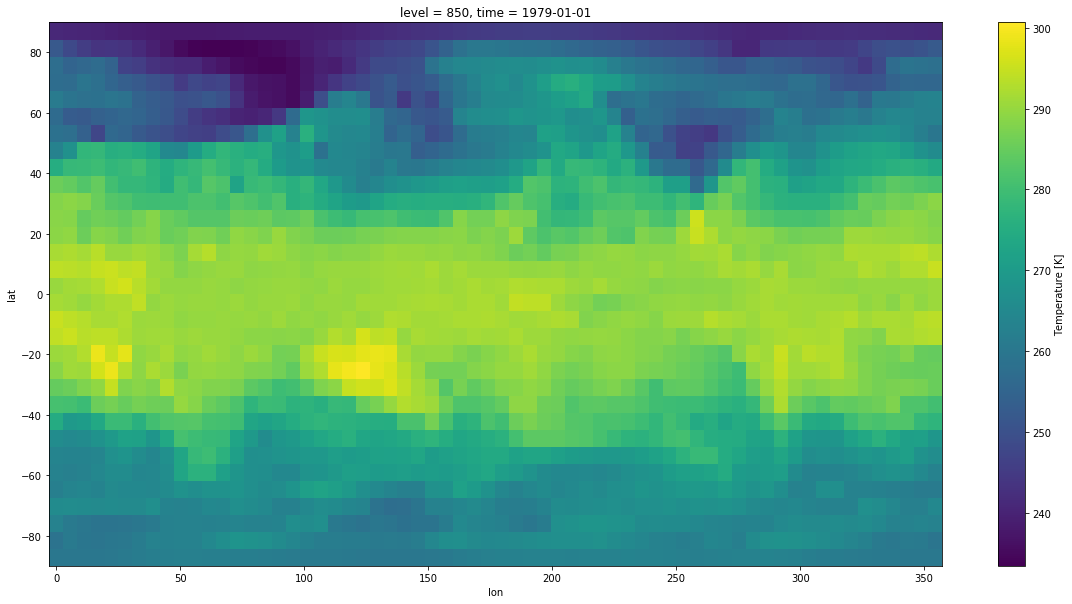

In [13]:
%%time
import matplotlib.pyplot as plt
data_5.t[0, ('level', [10])][0].plot(figsize=(20,10))

CPU times: user 3.13 s, sys: 50.3 s, total: 53.4 s
Wall time: 53.7 s


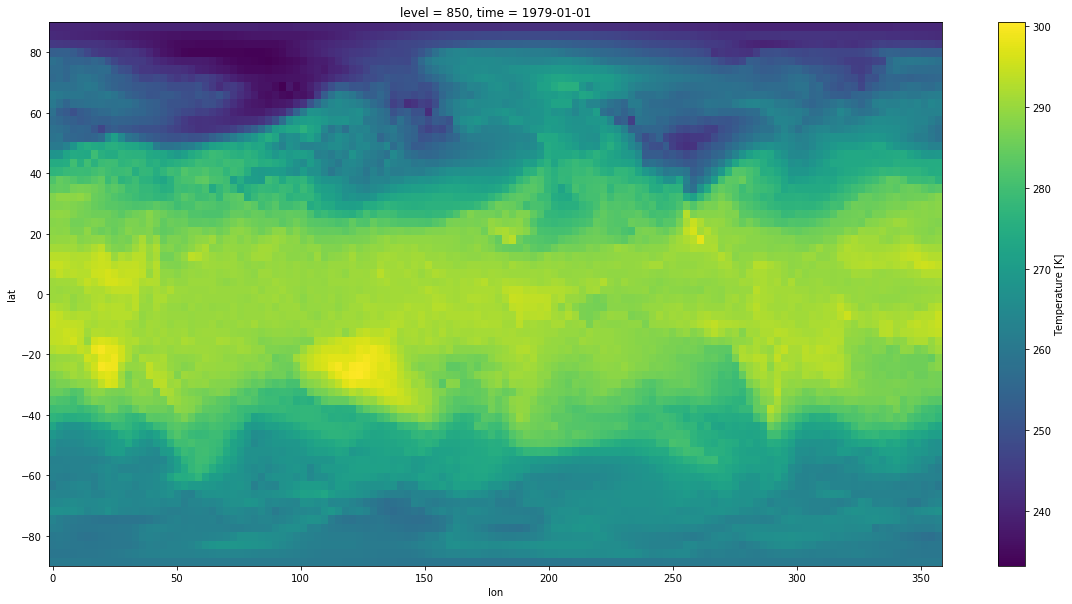

In [12]:
%%time
import matplotlib.pyplot as plt
data_2.t[0, ('level', [10])][0].plot(figsize=(20,10))

In [ ]:
%%time
import matplotlib.pyplot as plt
data_1.t[0, ('level', [10])][0].plot(figsize=(20,10))

## On Measuring Performance

We already learned a little bit about performance measurements, in the following two examples, you can try it yourself:

In [138]:
%%time 
# single year ()
import time

times = []

data = mf_dataset(resolution='5.625', year=1980, variables=['temperature'])
data = data.isel(level=[0, 4, 7, 8, 9, 10, 11])
singleyear = data

mib = data.nbytes/(1024**2)
print("Size (MiB):", mib)

times.append(time.time())
data.load()
times.append(time.time())


elapsed = times[-1] - times[0]
throughput = mib/elapsed

print("Elapsed:   ", elapsed)
print("MiB/s:     ", throughput)
print()

Size (MiB): 480.44277572631836
Elapsed:    7.428376913070679
MiB/s:      64.67668258471782

CPU times: user 1.89 s, sys: 5.73 s, total: 7.62 s
Wall time: 7.48 s


In [142]:
# 40 years
import time

times = []

data = mf_dataset(resolution='5.625', variables=['temperature'])
data = data.isel(level=[0, 4, 7, 8, 9, 10, 11])
fourty = data

mib = data.nbytes/(1024**2)
print("Size (MiB):", mib)

Size (MiB): 19178.300930023193


In [145]:
# Before you run this cell, be aware that it may crash your kernel if you did not allocate enough memory during job submission!
# Also note: Loading data adds some overhead for managment data structures: So the reported 19 GiB is the raw-data size without the overhead.

#times.append(time.time())
#data.load()
#times.append(time.time())


#elapsed = times[-1] - times[0]
#throughput = mib/elapsed

#print("Elapsed:   ", elapsed)
#print("MiB/s:     ", throughput)